## Android Tap and Sensor Fusion

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict as od
from numpy import mean, var
from scipy.stats import skew, kurtosis
import json
import matplotlib.pyplot as plt
import glob
import os
import ast
import seaborn as sns, numpy as np
%matplotlib inline
import matplotlib.dates as dates
import statsmodels.api as sm
import os, sys, inspect
sys.path.insert(0,'../Scripts/madgwickahrs.py')
from madgwickahrs import *
from quaternion import *

/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


##### Sensor Data Parser

In [3]:
ls ../Data/SensorInfo/

201711091951  201711092033  201711161638  201711182141


In [4]:
def parseSensorData(filename):
    x=pd.read_csv(filename)
    x.columns=x.columns.map(lambda x:str(x).strip())
    sensorNameDict=dict(zip(set(x.sensorName),[str(sensor).strip().partition(' ')[2] for sensor in (set(x.sensorName))]))
    x['sensorName']=x['sensorName'].replace(sensorNameDict)
    data_Accelerometer=x.loc[x.sensorName=="Accelerometer"].reset_index().drop(['index','sensorName'],axis=1)
    data_Gyroscope=x.loc[x.sensorName=="Gyroscope"].reset_index().drop(['index','sensorName'],axis=1)
    data_Magnetometer=x.loc[x.sensorName=="Magnetometer"].reset_index().drop(['index','sensorName'],axis=1)
    acc=data_Accelerometer[['timestamp','lastAccelerometerValues[0]','lastAccelerometerValues[1]','lastAccelerometerValues[2]']].groupby('timestamp').mean()
    gyr=data_Gyroscope[['timestamp','lastGyroscopeValues[0]','lastGyroscopeValues[1]','lastGyroscopeValues[2]']].groupby('timestamp').mean()
    mag=data_Magnetometer[['timestamp','lastMagnetometerValues[0]','lastMagnetometerValues[1]','lastMagnetometerValues[2]']].groupby('timestamp').mean()
    return acc,gyr,mag

In [5]:
from madgwick_py import madgwickahrs, quaternion

ImportError: No module named madgwick_py

##### Tap Data Parser

In [6]:
ls ../Data/TapInfo/

ml16-141402-201711091951-export.json  ml16-141402-201711161638-export.json
ml16-141402-201711092033-export.json  ml16-141402-201711182141-export.json


In [7]:
def parseTapData(filename):
    tapInfo=pd.read_json(filename)
    cols=['eventTime', 'pointerCount', 'source', 'buttonState', 'actionButton', 'id0', 'historySize', 'toolType0', 'flags', 'deviceId', 'downTime', 'action', 'y0', 'x0', 'metaState', 'edgeFlags']
    df=pd.DataFrame(columns=cols)
    for btnID, btn in tapInfo.btnID.iteritems():
        sample=ast.literal_eval(str(btn).replace('u\'','\''))
        for timestamp in sample.keys():
            event=ast.literal_eval(str(sample[timestamp]))
            if type(event) is dict:
                idx = event.keys()[0]
                row=str(event[idx]) 
            else:
                idx=0
                row=str(event[0])
            t=row.replace('MotionEvent ','').replace('[','').replace(']','').replace('=','\':\'').replace(', ','\', \'').replace('\'{ ','{\'').replace(' }\'','\'}')
            dt=ast.literal_eval(t)
            dx=pd.DataFrame.from_records([dt],index=[0])
            if '2' in dx.columns:
                dx=pd.DataFrame.from_records([dx['2'][0]],index=[0]) 
            dx['action']=dx['action'][0][7:]
            dx['id0']=idx
            dx['actionButton']=int(btnID)
            dx['buttonState']=long(timestamp)
            dx['downTime']=long(dx['downTime'])
            dx['eventTime']=long(dx['eventTime'])
            df=pd.concat([df,dx],axis=0)
    df=df.sort('eventTime').reset_index().drop(['index','metaState','deviceId','edgeFlags','flags','historySize','pointerCount','source','toolType0','id0','x0','y0'],axis=1)
    df=df[df['action']=='UP']
    return df

### Load all data

In [8]:
accData=od()
gyrData=od()
magData=od()
tapData=od()

In [9]:
for filename in glob.glob('../Data/SensorInfo/201711*'):
    key=filename.split('/')[-1]
    print(key)
    accData[key],gyrData[key],magData[key]=parseSensorData(filename)

201711092033
201711091951
201711161638
201711182141


In [10]:
for filename in glob.glob('../Data/TapInfo/ml16-141402-201711*'):
    key=filename.split('ml16-141402-')[-1].split('-')[0]
    print(key)
    tapData[key]=parseTapData(filename)

201711091951


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


201711092033
201711182141
201711161638


### Data Integration & Feature Extraction

In [11]:
data=od()

In [175]:
def getData(acc,gyr,mag,row):
        prior=50
        span=30
        win=row['eventTime']-row['downTime']
        a1=acc.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        g1=gyr.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        m1=mag.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        a2=acc.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))
        g2=gyr.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))
        m2=mag.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))

        d=pd.concat([
            pd.DataFrame([row['actionButton']],columns=['target']).T,
            a1.apply(mean).rename(lambda x:x+'_mean_D').T,
            a1.apply(var).rename(lambda x:x+'_var_D'),
            a1.apply(skew).rename(lambda x:x+'_skew_D'),
            a1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            g1.apply(mean).rename(lambda x:x+'_mean_D'),
            g1.apply(var).rename(lambda x:x+'_var_D'),
            g1.apply(skew).rename(lambda x:x+'_skew_D'),
            g1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            m1.apply(mean).rename(lambda x:x+'_mean_D'),
            m1.apply(var).rename(lambda x:x+'_var_D'),
            m1.apply(skew).rename(lambda x:x+'_skew_D'),
            m1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            a2.apply(mean).rename(lambda x:x+'_mean_U').T,
            a2.apply(var).rename(lambda x:x+'_var_U'),
            a2.apply(skew).rename(lambda x:x+'_skew_U'),
            a2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U'),
            g2.apply(mean).rename(lambda x:x+'_mean_U'),
            g2.apply(var).rename(lambda x:x+'_var_U'),
            g2.apply(skew).rename(lambda x:x+'_skew_U'),
            g2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U'),
            m2.apply(mean).rename(lambda x:x+'_mean_U'),
            m2.apply(var).rename(lambda x:x+'_var_U'),
            m2.apply(skew).rename(lambda x:x+'_skew_U'),
            m2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U')
        ]
            ,axis=0).T
        return d

In [176]:
def fusion(acc, gyr, mag, tap):
    df=pd.DataFrame()
    for idx,row in tap.iterrows():
        d=getData(acc,gyr,mag,row)
        df=df.append([d],ignore_index=True)
    return df

In [179]:
for key in tapData.keys():
        print key
        data[key]=fusion(accData[key], gyrData[key], magData[key], tapData[key])
        data[key].to_csv('../Data/Features/'+str(key)+'_features.csv')

201711091951
201711092033
201711182141
201711161638


In [180]:
data

NameError: name 'estimator0' is not defined

In [170]:
for key in data.keys():

In [159]:
for key in accData.keys():
    key='201711182141'
    a=accData[key]
    g=gyrData[key]
    m=magData[key]
    t=tapData[key]
    print t.head()

    sensors=pd.concat([a,g,m],axis=1)
    sensors=pd.DataFrame(sensors,index=range(sensors.index[0],sensors.index[-1])).fillna(method='bfill')
    target=pd.DataFrame()
    old=999
    for idx,row in sensors.iterrows():
        act=-1
        q=t.query('eventTime>='+str(idx)+' and downTime<='+str(idx))
        if len(q)>0:
            act=q.index[0]
        sensors.loc[idx,'target']=act
    break

  action  actionButton  buttonState    downTime   eventTime
1     UP           0.0   15316443.0  15316358.0  15316442.0
3     UP           0.0   15317178.0  15317093.0  15317177.0
5     UP           0.0   15317867.0  15317799.0  15317863.0
7     UP           0.0   15318677.0  15318594.0  15318674.0
9     UP           0.0   15319545.0  15319461.0  15319543.0


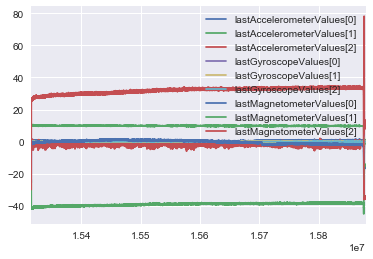

In [126]:
sensors.plot()

In [127]:
plt.show()

In [ ]:
ax = sns.plt(,fit=norm, kde=False)

In [13]:
def plotSensor(data):
    for key in data.keys():
        data[key].plot(title=key)
    plt.show()

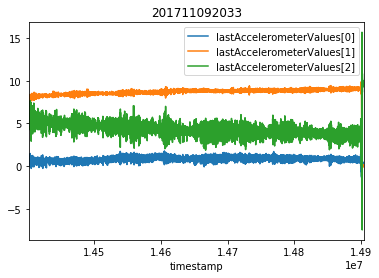

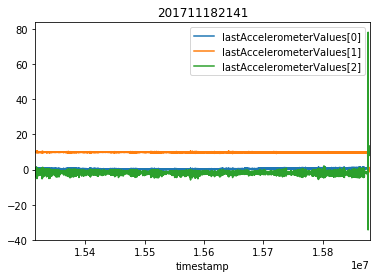

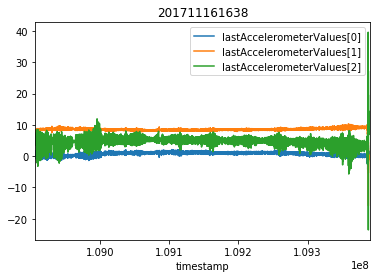

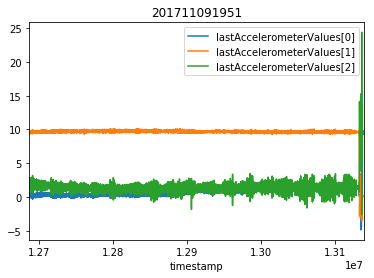

In [14]:
plotSensor(accData)

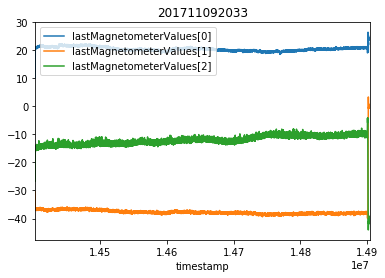

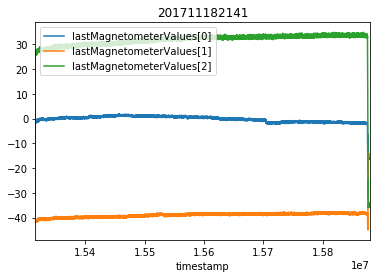

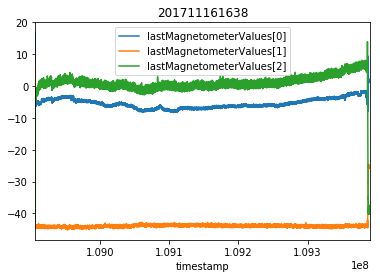

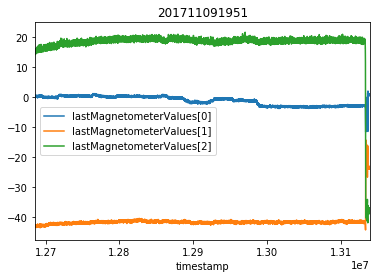

In [15]:
plotSensor(magData)

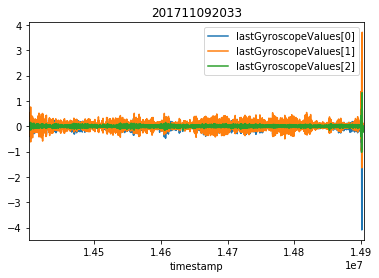

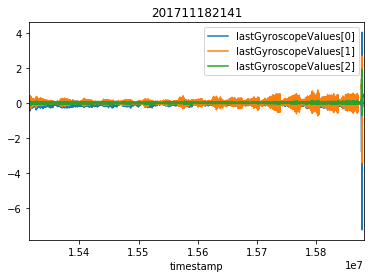

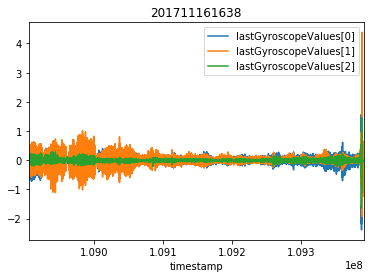

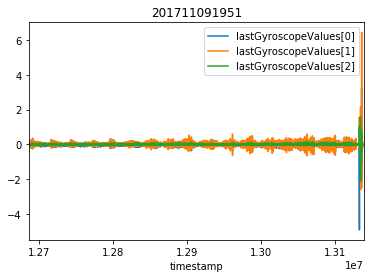

In [16]:
plotSensor(gyrData)

201711091951


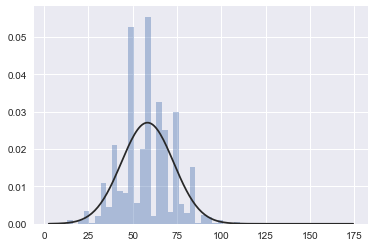

201711092033


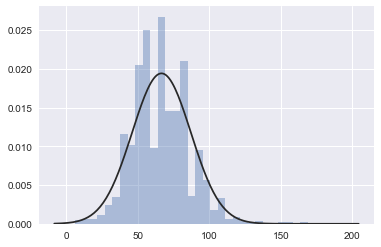

201711182141


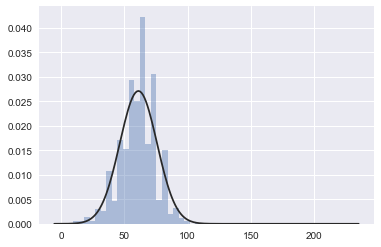

201711161638


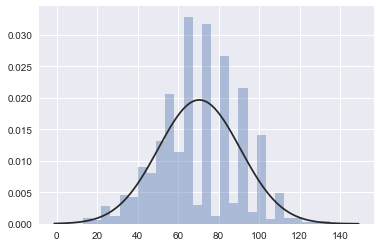

In [24]:
for key in tapData.keys():
    print(key)
    plotTapIntervalDist(tapData[key])
    plt.show()

In [18]:
from scipy.stats import norm
def plotTapIntervalDist(t):
    ax = sns.distplot((t.eventTime-t.downTime),fit=norm, kde=False)

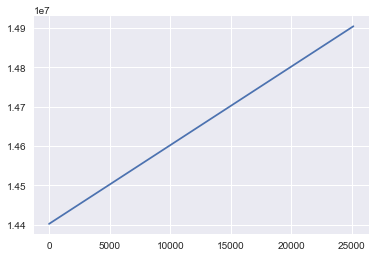

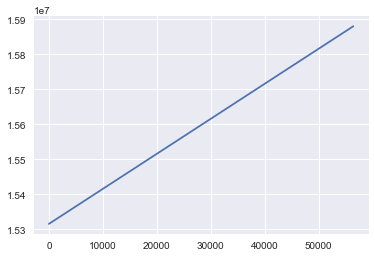

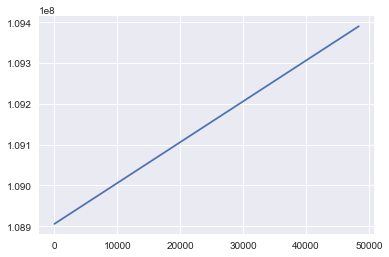

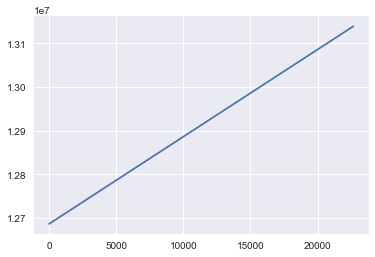

In [33]:

for key in magData.keys():
    plt.plot(magData[key].index)
    plt.show()


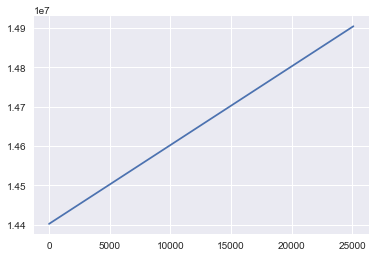

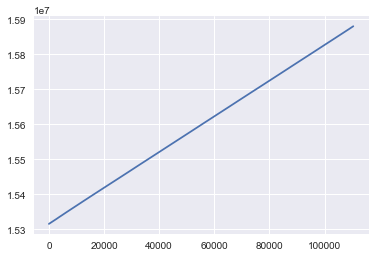

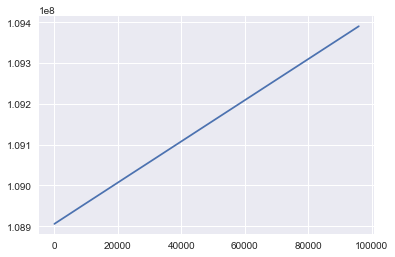

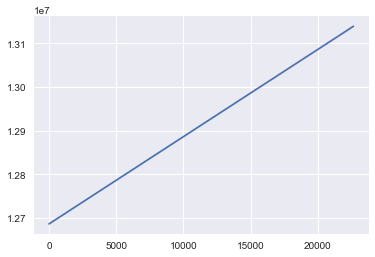

In [32]:
for key in gyrData.keys():
    plt.plot(gyrData[key].index)
    plt.show()

In [34]:
for key in accData.keys():
    print(accData[key].index)
    #plt.show()

Int64Index([14402109, 14402110, 14402219, 14402220, 14402221, 14402299,
            14402300, 14402327, 14402336, 14402356,
            ...
            14904135, 14904155, 14904175, 14904197, 14904215, 14904237,
            14904255, 14904275, 14904295, 14904315],
           dtype='int64', name=u'timestamp', length=25092)
Int64Index([15315114, 15315115, 15315116, 15315199, 15315200, 15315201,
            15315202, 15315277, 15315278, 15315279,
            ...
            15880084, 15880089, 15880096, 15880099, 15880105, 15880109,
            15880115, 15880119, 15880125, 15880129],
           dtype='int64', name=u'timestamp', length=111709)
Int64Index([108905671, 108905672, 108905673, 108905674, 108905675, 108905676,
            108905682, 108905821, 108905822, 108905823,
            ...
            109390355, 109390360, 109390364, 109390369, 109390374, 109390380,
            109390385, 109390392, 109390395, 109390400],
           dtype='int64', name=u'timestamp', length=96260)
Int64In

# fin.

In [ ]:
a = a.set_index(pd.DatetimeIndex(df['b']))

In [141]:
a.index.astype(int)

Int64Index([108905671, 108905672, 108905673, 108905674, 108905675, 108905676,
            108905682, 108905821, 108905822, 108905823,
            ...
            109390355, 109390360, 109390364, 109390369, 109390374, 109390380,
            109390385, 109390392, 109390395, 109390400],
           dtype='int64', name=u'timestamp', length=96260)

UnboundLocalError: local variable 'x' referenced before assignment

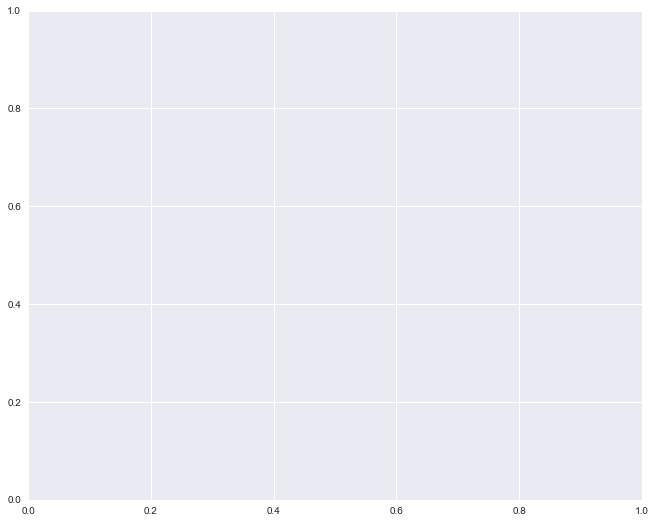

In [139]:
sns.tsplot(a)

In [78]:
for key in accData.keys():
    key='201711182141'
    a=accData[key]
    g=gyrData[key]
    m=magData[key]
    print key
    break
    
    

201711182141


In [79]:
a.index[1:]-a.index[:-1]

Int64Index([ 1,  1, 83,  1,  1,  1, 75,  1,  1,  5,
            ...
             5,  5,  7,  3,  6,  4,  6,  4,  6,  4],
           dtype='int64', name=u'timestamp', length=111708)

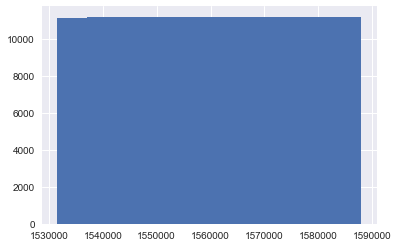

In [80]:
plt.hist(a.index/10)
plt.show()

In [81]:
len(m)

56410

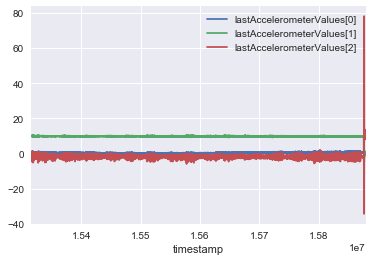

In [84]:
a.plot()

In [1]:
sensors=pd.concat([a,g,m],axis=1)
sensors=pd.DataFrame(sensors,index=range(sensors.index[0],sensors.index[-1])).fillna(method='bfill')
quats=pd.DataFrame()
for idx,row in sensors.iterrows():
    
    acc = np.array( [row['lastAccelerometerValues[0]'], row['lastAccelerometerValues[0]'], row['lastAccelerometerValues[0]']])
    gyr = np.array( [row['lastGyroscopeValues[0]'], row['lastGyroscopeValues[0]'], row['lastGyroscopeValues[0]']])
    mag = np.array( [row['lastMagnetometerValues[0]'], row['lastMagnetometerValues[0]'], row['lastMagnetometerValues[0]']])
    print acc
    gyr_rad = gyr * (np.pi/180)
    new_data.update(gyr_rad,acc,mag)
    quats=quats.append(pd.DataFrame([new_data.quaternion.q]))
    

NameError: name 'pd' is not defined

In [106]:


# No parameters filled in means it will use the parameters stated 
in the script (sampleperiod = 1/256, quaternion = [1 0 0 0], beta = 1)

new_data.update_imu(gyr_rad,acc)